In [1]:
import pandas as pd
from statsmodels.stats.contingency_tables import cochrans_q
import scipy.stats
import numpy as np
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import matplotlib

In [2]:
THRESHOLD = 0.05 #alpha significance level
PREDICTIONS_DIR = 'predictions'

tasks = {
    'binary': [0, 1], 
    'type': [0, 1, 2, 3]
}
representations = ['bow', 'freq', 'tfidf']
models = ['decision-tree', 'svm', 'naive-bayes', 'xgboost']
methods = ['SMOTETomek', 'RandomOver', 'ADASYN', 'RandomUnder', 'none']

In [3]:
#find the mode of a numpy array
def mode(array):
    freq = np.bincount(array)
    return np.argmax(freq)

In [4]:
def shorten_name(name):
    shortenings = {
    'decision-tree': 'dt',
    'naive-bayes-multinomial': 'nbm',
    'naive-bayes': 'nb',
    'xgboost': 'xgb',
    '-classification': '',
    '-type_of_antisemitism': '',}
    for long_version in shortenings:
        name = name.replace(long_version, shortenings[long_version])
    return name

#visualize the results of a post-hoc dunn analysis on a cochran's q test using matplotlib in a matrix
def visualize_dunn(dunn_values, names):
    names = [shorten_name(name) for name in names]
    
    plt.matshow(dunn_values)
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_xticklabels(labels=names,rotation=90)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_yticklabels(labels=names)
    
    #pulled these next two lines from stack overflow, just to display the values
    for (i, j), z in np.ndenumerate(dunn_values):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
    plt.pause(0.1)

In [5]:
#find the raw accuracy scores of all of the columns
def find_accuracy(df):
    accuracies = [1,]
    for column in [column for column in df.columns.values if column != 'Actual']:
        df[column] = df.apply(lambda x: int(x[column] == x['Actual']), axis=1)
        accuracies.append(df[column].mean())
    return accuracies

In [6]:
#combine columns in a dataframe whose names contain certain substrings
def combine_columns(df, substrings):
    '''
    df: the input dataframe that has many column names that contain certain common substrings
    substrings: the list of substrings used for combination
    
    returns: `output_df`, a DataFrame with `substrings` as its columns. Each row is the mode
    of the value for that row of all of the columns in `df` that contained that substring.
    '''
    output_df = pd.DataFrame()
    
    for column_substring in substrings:
        temp_df = pd.DataFrame()
        to_be_combined = [column for column in df.columns.values if column_substring in column]
        
        for column in to_be_combined:
            temp_df[column] = df[column]
            
        array = np.array(temp_df).astype(int)
        array = [mode(row) for row in array]
            
        output_df[column_substring] = array
    
    return output_df

In [7]:
#find which models performed best using basic accuracy score
def evaluate_models(df, substrings):
    output_df = pd.DataFrame()
    temp_df = combine_columns(df, substrings)
    for column in substrings:
        temp_df[column] = temp_df[column] == df['Actual']
        output_df[column] = [sum(temp_df[column])/len(temp_df),]
    output_df.index = ['Score']
    if 'index' in output_df.columns.values: del output_df['index']
    return output_df

#test model significance difference w/ Friedman Chi^2 while combining certain columns
def test_model_difference(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    cochran_result = cochrans_q(columns)
    return cochran_result

def post_hoc_tests(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    p_values = sp.posthoc_dunn(columns)
    return p_values

In [8]:
#get a list of binary dfs of whether or not they fit with a particular classification
def get_dfs(df, classifications):
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    return dfs

#find specific rankings for each model
def overall_evaluation(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    score_df = pd.DataFrame()
    dfs = get_dfs(df, classifications)
        
    for (i, temp_df) in enumerate(dfs):
        temp_df = evaluate_models(temp_df, temp_df.columns.values).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
            
        score_df[f'Score {i}'] = temp_df['Score']
    
    score_df['Mean score'] = score_df.mean(axis=1)
    score_df['Accuracy'] = find_accuracy(df)
    score_df = score_df.sort_values('Mean score', ascending = False)
    cochran_result = cochrans_q(df)
    post_hoc_p = pd.DataFrame()
    if cochran_result.pvalue <= THRESHOLD:
        post_hoc_p = post_hoc_tests(df, df.columns.values)
    
    print(f'Task: {task}.')
    print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
    if cochran_result.pvalue <= THRESHOLD:
        print('Post-hoc Dunn test array:')
        visualize_dunn(post_hoc_p, df.columns.values)
    
    score_df.index = [shorten_name(name) for name in score_df.index]
    print(score_df)
    print(f'\nMean: {score_df["Mean score"].mean()}')
    print('\n\n')
    return score_df

In [9]:
def evaluate_rep_model(grouping, dfs):
    final_df = pd.DataFrame()
    
    for i, df in enumerate(dfs):
        temp_df = evaluate_models(df, grouping).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
        
        temp_df.columns = ['Score']
        final_df[f'Score {i}'] = temp_df['Score']
        
    return final_df

#evaluate algorithms and representations, find significance level
def algorithm_and_rep_eval(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    for grouping in [representations, models]:
        score_df = evaluate_rep_model(grouping, dfs)
        score_df['Mean score'] = score_df.mean(axis=1)
        score_df = score_df.sort_values('Mean score', ascending = False)
        
        combined_df = combine_columns(df, grouping)
        cochran_result = cochrans_q(combined_df)
        if cochran_result.pvalue <= THRESHOLD:
            post_hoc_p = post_hoc_tests(combined_df, grouping)
        
        print(f'Task: {task}. Grouping: {grouping}.')
        print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
        if cochran_result.pvalue <= THRESHOLD:
            print('Post-hoc Dunn test array:')
            visualize_dunn(post_hoc_p, grouping)
        
        score_df.index = [shorten_name(name) for name in score_df.index]
        print(f"Scores: \n{score_df}")
        print(f'\nMean: {score_df["Mean score"].mean()}')
        print('\n\n')

In [10]:
#evaluate the overall resampling methods, perform friedman test and post-hoc nemenyi
def evaluate_resampling(overall_df, indeces):
    columns = [overall_df[column] for column in overall_df.columns.values]
    statistic, pvalue = scipy.stats.friedmanchisquare(*columns)
    overall_df.loc[len(overall_df)] = overall_df.apply(lambda x: np.mean(x))
    indeces.append('Mean')
    overall_df.index = indeces
    print('\nOverall scores:')
    print(f'Friedman Chi Square Statistic: {statistic}. p-value: {pvalue}.')
    print(overall_df)
    if pvalue <= THRESHOLD:
        overall_df = overall_df.transpose()
        columns = [overall_df[column] for column in overall_df.columns.values]
        p_values = sp.posthoc_nemenyi_friedman(columns)
        print('\nPost-hoc Dunn test array:')
        visualize_dunn(p_values, list(overall_df.index))

The below visualizations and `DataFrame`s contain testing information on the various algorithms and representation methods used to create models. Data is shown on two tasks, 'binary,' referring to the binary classification of whether or not a particular tweet is antisemitic, and 'type,' referring to classifying the tweet with a particular type of antisemitism. The model evaluation was done in two stages, first the overall evaluation, then the grouped evaluation for different algorithms and representations. Some names are shortened during presentation: `decision-tree` is shortened to `dt`, `naive-bayes-multinomial` to `nbm`, and `naive-bayes` to `nb`.

For the overall evaluation, the model scores were generated using the arithmetic mean of the recalls on each individual class, with a Cochran's Q test being performed on a matrix that contained columns for each model and in each column contained a `1` where the model found the correct answer, and `0` where the model found the incorrect answer. Then, if the Q test found an *p*-value lower than the specified global `THRESHOLD` constant, it performs a post-hoc Dunn text, which is then visualized in the form of a matrix, with higher values meaning lighter colors and a greater correlation between two models' answers. Then, the score `DataFrame` is shown, with a column entitled `Mean score` for the arithmetic mean of the recall of the model on each class. There are additional columns entitles `Score {x}`, with `{x}` being the specific class that that column gives the recall of for each model. Finally, an overall mean of the `Mean score` column is given.

For the model grouping evaluation, models are grouped into classes either by their representation or algorithm type. The most common answer across all models of this type is then taken as the answer for this grouping. Following this, the same process as above was used.


Task: Binary


Method: SMOTETomek

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


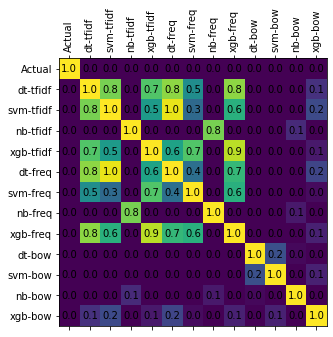

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
dt-freq    0.840183  0.529070    0.684626  0.595902
dt-tfidf   0.851598  0.514535    0.683067  0.752459
xgb-freq   0.871005  0.479651    0.675328  0.763115
xgb-tfidf  0.884703  0.453488    0.669096  0.600820
svm-freq   0.915525  0.398256    0.656890  0.751639
xgb-bow    0.832192  0.465116    0.648654  0.760656
dt-bow     0.747717  0.488372    0.618044  0.674590
svm-tfidf  0.949772  0.247093    0.598432  0.756557
svm-bow    0.845890  0.316860    0.581375  0.769672
nb-bow     0.732877  0.369186    0.551031  0.696721
nb-tfidf   0.692922  0.366279    0.529601  0.630328
nb-freq    0.682648  0.375000    0.528824  0.728689

Mean: 0.6480745746236347



Task: binary. Grouping: ['bow', 'freq', 'tfidf'].
Cochran's Q test p-value: 2.216976723422286e-07
Post-hoc Dunn test array:


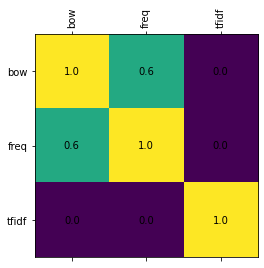

Scores: 
        Score 0   Score 1  Mean score
freq   0.930365  0.383721    0.657043
tfidf  0.946347  0.276163    0.611255
bow    0.886986  0.299419    0.593202

Mean: 0.6205001592863969



Task: binary. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 5.255854413409259e-42
Post-hoc Dunn test array:


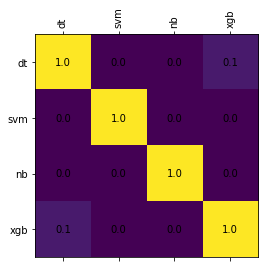

Scores: 
      Score 0   Score 1  Mean score
dt   0.868721  0.502907    0.685814
xgb  0.894977  0.462209    0.678593
svm  0.941781  0.331395    0.636588
nb   0.691781  0.369186    0.530483

Mean: 0.6328697435489008




Method: RandomOver

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


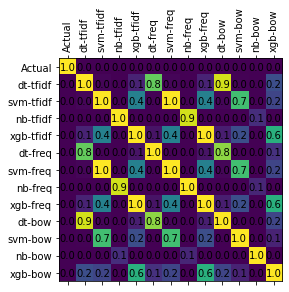

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
xgb-tfidf  0.843607  0.514535    0.679071  0.713934
xgb-freq   0.844749  0.511628    0.678188  0.750820
svm-bow    0.896119  0.459302    0.677711  0.600820
xgb-bow    0.840183  0.491279    0.665731  0.765574
svm-freq   0.898402  0.427326    0.662864  0.765574
dt-bow     0.801370  0.505814    0.653592  0.718033
dt-tfidf   0.809361  0.491279    0.650320  0.599180
dt-freq    0.808219  0.473837    0.641028  0.750820
svm-tfidf  0.930365  0.345930    0.638148  0.719672
nb-bow     0.732877  0.366279    0.549578  0.772951
nb-freq    0.686073  0.377907    0.531990  0.741803
nb-tfidf   0.692922  0.366279    0.529601  0.629508

Mean: 0.6582939201607568



Task: binary. Grouping: ['bow', 'freq', 'tfidf'].
Cochran's Q test p-value: 0.0007115105585124322
Post-hoc Dunn test array:


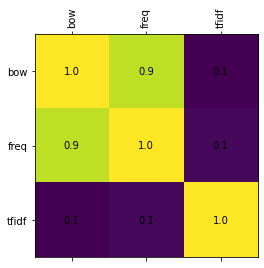

Scores: 
        Score 0   Score 1  Mean score
freq   0.920091  0.406977    0.663534
bow    0.915525  0.401163    0.658344
tfidf  0.932648  0.351744    0.642196

Mean: 0.6546914268521469



Task: binary. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 2.1197923532922733e-22
Post-hoc Dunn test array:


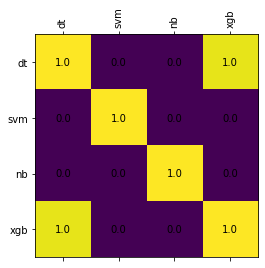

Scores: 
      Score 0   Score 1  Mean score
xgb  0.852740  0.508721    0.680730
svm  0.912100  0.427326    0.669713
dt   0.840183  0.473837    0.657010
nb   0.692922  0.372093    0.532508

Mean: 0.6349902437081874




Method: ADASYN

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


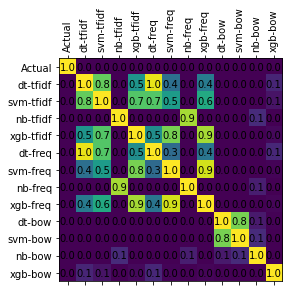

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
dt-tfidf   0.832192  0.526163    0.679177  0.763115
dt-freq    0.835616  0.514535    0.675076  0.745082
xgb-freq   0.875571  0.470930    0.673251  0.758197
xgb-tfidf  0.875571  0.459302    0.667437  0.600000
svm-freq   0.897260  0.421512    0.659386  0.751639
xgb-bow    0.823059  0.438953    0.631006  0.596721
svm-tfidf  0.937215  0.279070    0.608142  0.745902
dt-bow     0.742009  0.465116    0.603563  0.663934
svm-bow    0.789954  0.325581    0.557768  0.761475
nb-bow     0.732877  0.366279    0.549578  0.659016
nb-freq    0.682648  0.377907    0.530278  0.714754
nb-tfidf   0.690639  0.369186    0.529913  0.629508

Mean: 0.6434287213795019



Task: binary. Grouping: ['bow', 'freq', 'tfidf'].
Cochran's Q test p-value: 0.00020104133988157064
Post-hoc Dunn test array:


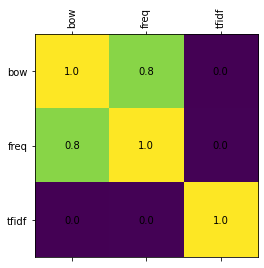

Scores: 
        Score 0   Score 1  Mean score
freq   0.925799  0.404070    0.664934
tfidf  0.939498  0.311047    0.625272
bow    0.869863  0.273256    0.571559

Mean: 0.6205886517291423



Task: binary. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 3.267914002393684e-37
Post-hoc Dunn test array:


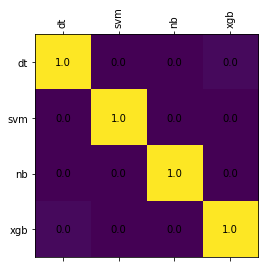

Scores: 
      Score 0   Score 1  Mean score
dt   0.855023  0.505814    0.680418
xgb  0.888128  0.453488    0.670808
svm  0.930365  0.354651    0.642508
nb   0.689498  0.372093    0.530795

Mean: 0.6311325262822556




Method: RandomUnder

Task: binary.
Cochran's Q test p-value: 3.817404667638128e-231
Post-hoc Dunn test array:


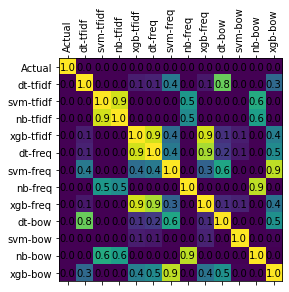

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.794521  0.563953    0.679237  0.660656
svm-freq   0.678082  0.674419    0.676250  0.587705
dt-freq    0.715753  0.636628    0.676191  0.695082
xgb-freq   0.727169  0.619186    0.673177  0.573770
xgb-bow    0.691781  0.648256    0.670018  0.693443
xgb-tfidf  0.731735  0.601744    0.666740  0.575410
dt-bow     0.670091  0.656977    0.663534  0.696721
dt-tfidf   0.678082  0.616279    0.647181  0.677049
svm-tfidf  0.489726  0.793605    0.641665  0.679508
nb-freq    0.573059  0.625000    0.599030  0.729508
nb-bow     0.578767  0.601744    0.590256  0.666393
nb-tfidf   0.557078  0.616279    0.586678  0.585246

Mean: 0.674612096780781



Task: binary. Grouping: ['bow', 'freq', 'tfidf'].
Cochran's Q test p-value: 3.651050802322683e-05
Post-hoc Dunn test array:


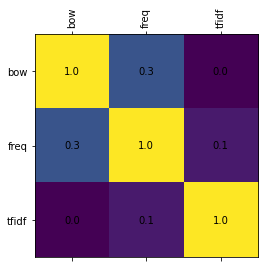

Scores: 
        Score 0   Score 1  Mean score
bow    0.801370  0.566860    0.684115
tfidf  0.743151  0.613372    0.678261
freq   0.771689  0.566860    0.669275

Mean: 0.6772171781529858



Task: binary. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 4.484700782744336e-19
Post-hoc Dunn test array:


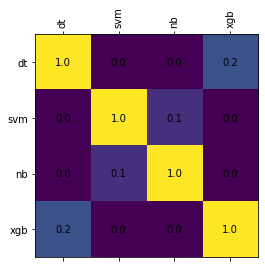

Scores: 
      Score 0   Score 1  Mean score
svm  0.655251  0.703488    0.679370
xgb  0.747717  0.610465    0.679091
dt   0.719178  0.619186    0.669182
nb   0.586758  0.633721    0.610239

Mean: 0.659470571838165




Method: none

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


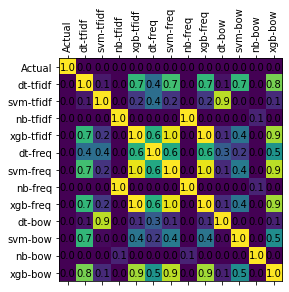

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
dt-tfidf   0.853881  0.531977    0.692929  0.598361
dt-freq    0.841324  0.502907    0.672116  0.754918
xgb-tfidf  0.878995  0.438953    0.658974  0.745902
xgb-freq   0.878995  0.438953    0.658974  0.755738
svm-bow    0.916667  0.401163    0.658915  0.598361
xgb-bow    0.890411  0.421512    0.655961  0.754918
dt-bow     0.831050  0.459302    0.645176  0.726230
svm-freq   0.963470  0.226744    0.595107  0.728689
nb-bow     0.732877  0.366279    0.549578  0.771311
nb-freq    0.683790  0.380814    0.532302  0.758197
nb-tfidf   0.688356  0.369186    0.528771  0.629508
svm-tfidf  0.992009  0.058140    0.525074  0.763115

Mean: 0.6441444890990925



Task: binary. Grouping: ['bow', 'freq', 'tfidf'].
Cochran's Q test p-value: 3.98496658714212e-20
Post-hoc Dunn test array:


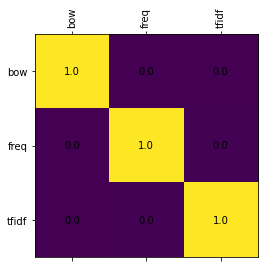

Scores: 
        Score 0   Score 1  Mean score
bow    0.934932  0.351744    0.643338
freq   0.953196  0.267442    0.610319
tfidf  0.972603  0.188953    0.580778

Mean: 0.6114783547485044



Task: binary. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 3.5410391621378707e-62
Post-hoc Dunn test array:


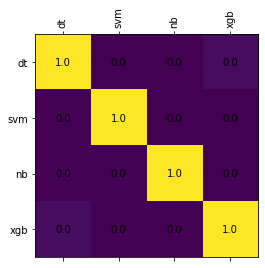

Scores: 
      Score 0   Score 1  Mean score
dt   0.858447  0.511628    0.685038
xgb  0.878995  0.438953    0.658974
svm  0.963470  0.215116    0.589293
nb   0.690639  0.375000    0.532820

Mean: 0.6165312732292663




Overall scores:
Friedman Chi Square Statistic: 10.944680851063834. p-value: 0.027192810855001952.
           SMOTETomek  RandomOver    ADASYN  RandomUnder      none
Actual       1.000000    1.000000  1.000000     1.000000  1.000000
dt-freq      0.684626    0.641028  0.675076     0.676191  0.672116
dt-tfidf     0.683067    0.650320  0.679177     0.647181  0.692929
xgb-freq     0.675328    0.678188  0.673251     0.673177  0.658974
xgb-tfidf    0.669096    0.679071  0.667437     0.666740  0.658974
svm-freq     0.656890    0.662864  0.659386     0.676250  0.595107
xgb-bow      0.648654    0.665731  0.631006     0.670018  0.655961
dt-bow       0.618044    0.653592  0.603563     0.663534  0.645176
svm-tfidf    0.598432    0.638148  0.608142     0.641665  0.525074
svm-bow      

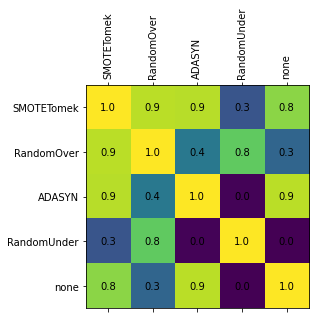


Task: Type


Method: SMOTETomek

Task: type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


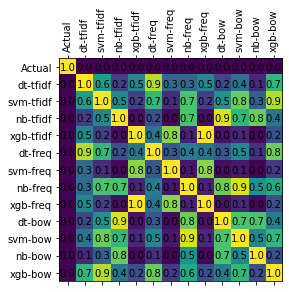

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.617647    0.375  0.333333  0.430894    0.439219  0.544118
xgb-tfidf  0.658824    0.000  0.512821  0.560976    0.433155  0.591176
xgb-freq   0.676471    0.000  0.461538  0.552846    0.422714  0.555882
dt-freq    0.652941    0.000  0.410256  0.504065    0.391816  0.526471
dt-tfidf   0.652941    0.000  0.384615  0.528455    0.391503  0.511765
xgb-bow    0.664706    0.000  0.282051  0.495935    0.360673  0.523529
svm-freq   0.847059    0.000  0.076923  0.463415    0.346849  0.538235
nb-freq    0.647059    0.000  0.230769  0.479675    0.339376  0.497059
svm-bow    0.741176    0.000  0.153846  0.382114    0.319284  0.508824
nb-tfidf   0.676471    0.000  0.128205  0.430894    0.308893  0.591176
nb-bow     0.664706    0.000  0.153846  0.406504    0.306264  0.600000
svm-tfidf  0.929412    0.000  0.025641  0.195122    0.287544  0.561765

Mean:

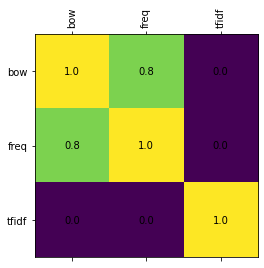

Scores: 
        Score 0  Score 1   Score 2   Score 3  Mean score
freq   0.829412      0.0  0.307692  0.455285    0.398097
tfidf  0.888235      0.0  0.230769  0.300813    0.354954
bow    0.776471      0.0  0.230769  0.365854    0.343273

Mean: 0.36544163631681564



Task: type. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 7.023625916588474e-13
Post-hoc Dunn test array:


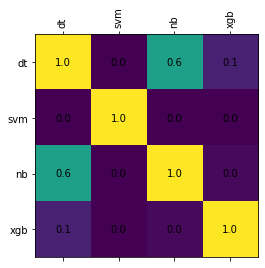

Scores: 
      Score 0  Score 1   Score 2   Score 3  Mean score
xgb  0.658824      0.0  0.512821  0.560976    0.433155
dt   0.723529      0.0  0.384615  0.512195    0.405085
nb   0.670588      0.0  0.179487  0.455285    0.326340
svm  0.894118      0.0  0.025641  0.284553    0.301078

Mean: 0.36641444101092596




Method: RandomOver

Task: type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


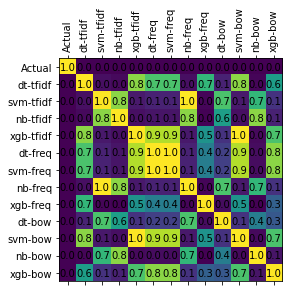

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-freq    0.647059    0.250  0.410256  0.577236    0.471138  0.591176
xgb-freq   0.676471    0.125  0.461538  0.617886    0.470224  0.585294
dt-tfidf   0.658824    0.125  0.461538  0.593496    0.459714  0.532353
xgb-tfidf  0.670588    0.125  0.461538  0.552846    0.452493  0.585294
xgb-bow    0.664706    0.000  0.410256  0.544715    0.404919  0.617647
svm-bow    0.829412    0.000  0.153846  0.439024    0.355571  0.508824
dt-bow     0.641176    0.000  0.230769  0.512195    0.346035  0.576471
svm-freq   0.841176    0.000  0.076923  0.430894    0.337248  0.517647
nb-freq    0.641176    0.000  0.230769  0.471545    0.335873  0.500000
nb-tfidf   0.676471    0.000  0.128205  0.430894    0.308893  0.591176
nb-bow     0.664706    0.000  0.153846  0.414634    0.308297  0.517647
svm-tfidf  0.876471    0.000  0.025641  0.211382    0.278373  0.600000

Mean:

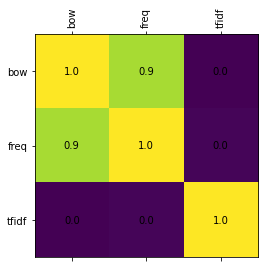

Scores: 
        Score 0  Score 1   Score 2   Score 3  Mean score
freq   0.835294    0.125  0.256410  0.471545    0.422062
bow    0.823529    0.000  0.307692  0.430894    0.390529
tfidf  0.835294    0.000  0.256410  0.325203    0.354227

Mean: 0.3889393953328673



Task: type. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 2.369746154416914e-08
Post-hoc Dunn test array:


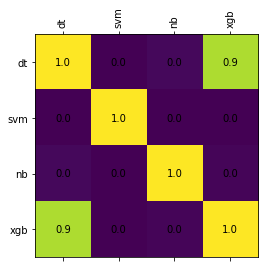

Scores: 
      Score 0  Score 1   Score 2   Score 3  Mean score
dt   0.694118    0.125  0.435897  0.617886    0.468225
xgb  0.670588    0.125  0.461538  0.593496    0.462656
nb   0.670588    0.000  0.179487  0.447154    0.324307
svm  0.864706    0.000  0.025641  0.373984    0.316083

Mean: 0.3928177767354597




Method: ADASYN

Task: type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


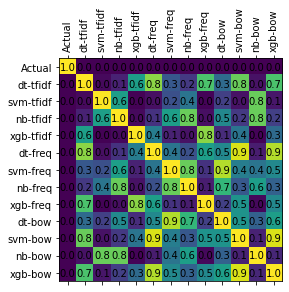

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000     1.00  1.000000  1.000000    1.000000  1.000000
xgb-tfidf  0.700000     0.00  0.410256  0.569106    0.419841  0.570588
xgb-freq   0.694118     0.00  0.410256  0.552846    0.414305  0.535294
dt-bow     0.670588     0.25  0.230769  0.479675    0.407758  0.594118
dt-tfidf   0.647059     0.00  0.384615  0.585366    0.404260  0.567647
dt-freq    0.647059     0.00  0.410256  0.552846    0.402540  0.500000
xgb-bow    0.705882     0.00  0.256410  0.504065    0.366589  0.602941
nb-freq    0.647059     0.00  0.230769  0.479675    0.339376  0.564706
nb-tfidf   0.676471     0.00  0.128205  0.439024    0.310925  0.523529
nb-bow     0.664706     0.00  0.153846  0.414634    0.308297  0.541176
svm-bow    0.905882     0.00  0.000000  0.317073    0.305739  0.488235
svm-freq   0.894118     0.00  0.000000  0.243902    0.284505  0.511765
svm-tfidf  0.929412     0.00  0.000000  0.065041    0.248613  0.579412

Mean:

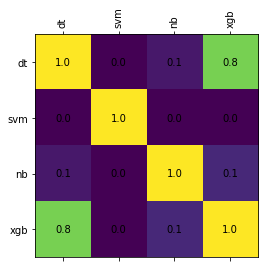

Scores: 
      Score 0  Score 1   Score 2   Score 3  Mean score
xgb  0.694118      0.0  0.410256  0.552846    0.414305
dt   0.670588      0.0  0.384615  0.569106    0.406077
nb   0.670588      0.0  0.179487  0.455285    0.326340
svm  0.929412      0.0  0.000000  0.219512    0.287231

Mean: 0.3584883015119744




Method: RandomUnder

Task: type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


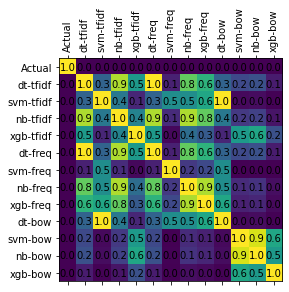

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
xgb-freq   0.329412    0.250  0.717949  0.284553    0.395478  0.376471
dt-bow     0.476471    0.375  0.512821  0.195122    0.389853  0.344118
nb-freq    0.370588    0.375  0.538462  0.260163    0.386053  0.350000
dt-tfidf   0.388235    0.500  0.256410  0.284553    0.357300  0.338235
nb-tfidf   0.388235    0.375  0.384615  0.268293    0.354036  0.402941
dt-freq    0.352941    0.250  0.487179  0.276423    0.341636  0.355882
nb-bow     0.311765    0.250  0.358974  0.252033    0.293193  0.291176
xgb-tfidf  0.411765    0.250  0.282051  0.195122    0.284734  0.314706
svm-freq   0.505882    0.125  0.102564  0.373984    0.276858  0.376471
svm-bow    0.305882    0.250  0.230769  0.292683    0.269834  0.294118
svm-tfidf  0.605882    0.125  0.076923  0.170732    0.244634  0.338235
xgb-bow    0.305882    0.125  0.282051  0.227642    0.235144  0.270588

Mean:

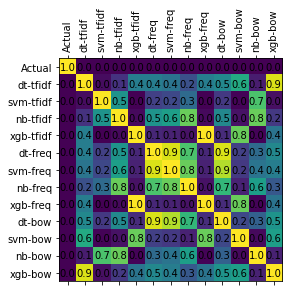

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
xgb-tfidf  0.711765    0.000  0.410256  0.552846    0.418717  0.602941
xgb-freq   0.711765    0.000  0.410256  0.552846    0.418717  0.538235
dt-tfidf   0.629412    0.000  0.358974  0.593496    0.395471  0.500000
xgb-bow    0.688235    0.000  0.358974  0.504065    0.387819  0.523529
dt-bow     0.688235    0.125  0.256410  0.455285    0.381233  0.535294
dt-freq    0.611765    0.000  0.358974  0.528455    0.374799  0.567647
nb-freq    0.647059    0.000  0.230769  0.479675    0.339376  0.591176
svm-bow    0.894118    0.000  0.000000  0.398374    0.323123  0.511765
nb-tfidf   0.676471    0.000  0.128205  0.439024    0.310925  0.602941
nb-bow     0.664706    0.000  0.153846  0.414634    0.308297  0.541176
svm-freq   0.905882    0.000  0.000000  0.227642    0.283381  0.485294
svm-tfidf  0.941176    0.000  0.000000  0.040650    0.245457  0.570588

Mean:

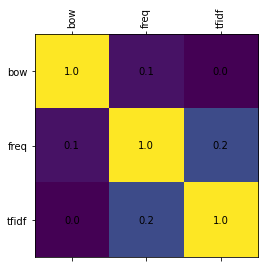

Scores: 
        Score 0  Score 1   Score 2   Score 3  Mean score
bow    0.864706      0.0  0.282051  0.414634    0.390348
freq   0.888235      0.0  0.179487  0.349593    0.354329
tfidf  0.894118      0.0  0.128205  0.268293    0.322654

Mean: 0.3557768948730211



Task: type. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 1.1022659495648407e-19
Post-hoc Dunn test array:


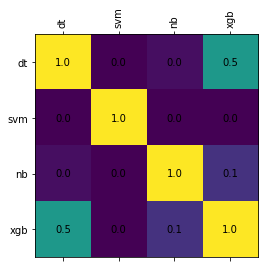

Scores: 
      Score 0  Score 1   Score 2   Score 3  Mean score
xgb  0.711765      0.0  0.410256  0.552846    0.418717
dt   0.652941      0.0  0.358974  0.560976    0.393223
nb   0.670588      0.0  0.179487  0.455285    0.326340
svm  0.929412      0.0  0.000000  0.203252    0.283166

Mean: 0.3553613471655078




Overall scores:
Friedman Chi Square Statistic: 10.678260869565236. p-value: 0.03042809769563688.
           SMOTETomek  RandomOver    ADASYN  RandomUnder      none
Actual       1.000000    1.000000  1.000000     1.000000  1.000000
dt-bow       0.439219    0.346035  0.407758     0.389853  0.381233
xgb-tfidf    0.433155    0.452493  0.419841     0.284734  0.418717
xgb-freq     0.422714    0.470224  0.414305     0.395478  0.418717
dt-freq      0.391816    0.471138  0.402540     0.341636  0.374799
dt-tfidf     0.391503    0.459714  0.404260     0.357300  0.395471
xgb-bow      0.360673    0.404919  0.366589     0.235144  0.387819
svm-freq     0.346849    0.337248  0.284505     0.276

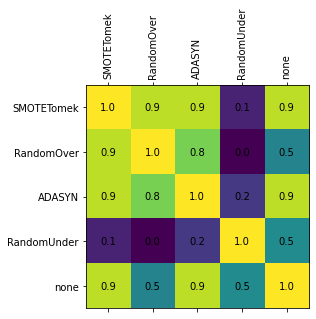

In [11]:
for task in tasks:
    print(f'\nTask: {task.title()}\n')
    overall_df = pd.DataFrame()
    indeces = []
    for method in methods:
        print(f'\nMethod: {method}\n')
        temp_df = overall_evaluation(task, tasks[task], method) #find the rankings for all models
        if not indeces:
            indeces = list(temp_df.index)
        overall_df[method] = temp_df['Mean score']
        algorithm_and_rep_eval(task, tasks[task], method) #group representations and algorithms together, evaluate
    evaluate_resampling(overall_df, indeces)